In [8]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\19241\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\19241\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Load the training dataset
train_data = pd.read_csv('train.csv')
# Display the first few records
#train_data.head()

In [10]:
# Check for missing values in the dataset
missing_values = train_data.isnull().sum()
missing_values

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [11]:
# Check the distribution of the target variable
label_distribution = train_data['label'].value_counts(normalize=True)

label_distribution

label
1    0.500625
0    0.499375
Name: proportion, dtype: float64

In [12]:
# Fill missing values
train_data['title'].fillna('missing', inplace=True)
train_data['author'].fillna('Unknown', inplace=True)
train_data['text'].fillna('missing', inplace=True)

# Verify if all missing values are filled
missing_after_fill = train_data.isnull().sum()

missing_after_fill

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [13]:
# Modified text preprocessing function without lemmatization
def preprocess_text_basic(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and non-word characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Testing the basic preprocessing function on a small sample of the dataset
sample_data_basic = train_data['text'][:5].apply(preprocess_text_basic)
sample_data_basic

0    house dem aide we didnt even see comeys letter...
1    ever get the feeling your life circles the rou...
2    why the truth might get you fired october   \r...
3    videos  civilians killed in single us airstrik...
4    print \r\nan iranian woman has been sentenced ...
Name: text, dtype: object

In [14]:
# Applying the basic preprocessing function to the entire dataset
train_data['text'] = train_data['text'].apply(preprocess_text_basic)
train_data['title'] = train_data['title'].apply(preprocess_text_basic)

# Displaying the first few rows of the preprocessed dataset
train_data.head()


,id,title,author,text,label
0,0,house dem aide we didnt even see comeys letter...,Darrell Lucus,house dem aide we didnt even see comeys letter...,1
1,1,flynn hillary clinton big woman on campus bre...,Daniel J. Flynn,ever get the feeling your life circles the rou...,0
2,2,why the truth might get you fired,Consortiumnews.com,why the truth might get you fired october \r...,1
3,3,civilians killed in single us airstrike have ...,Jessica Purkiss,videos civilians killed in single us airstrik...,1
4,4,iranian woman jailed for fictional unpublished...,Howard Portnoy,print \r\nan iranian woman has been sentenced ...,1


In [15]:
# Reloading the dataset and filling missing values as per previous steps
train_data = pd.read_csv('train.csv')
train_data['title'].fillna('missing', inplace=True)
train_data['author'].fillna('Unknown', inplace=True)
train_data['text'].fillna('missing', inplace=True)

# Proceeding with TF-IDF Vectorization
tfidf_train = tfidf_vectorizer.fit_transform(train_data['text'])

# TF-IDF Vectorization for text and title
vectorizer_text = TfidfVectorizer(max_features=5000)
X_text = vectorizer_text.fit_transform(train_data['text']).toarray()

vectorizer_title = TfidfVectorizer(max_features=1000)
X_title = vectorizer_title.fit_transform(train_data['title']).toarray()

# One-hot encoding for authors
encoder = OneHotEncoder()
X_author = encoder.fit_transform(train_data[['author']]).toarray()

# Checking the shape of our new vectorized data
tfidf_train.shape


(20800, 5000)

In [16]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets (80% training, 20% validation)
X = tfidf_train
y = train_data['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_val.shape

((16640, 5000), (4160, 5000))

In [17]:
from sklearn.neural_network import MLPClassifier

# Initializing the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=100, activation='relu', solver='adam', random_state=42)

# Training the model
mlp.fit(X_train, y_train)

# Evaluating the model on validation data
val_score = mlp.score(X_val, y_val)
val_score


0.9490384615384615

In [18]:
import numpy as np
import pandas as pd

def predict_all_articles(df, model, vectorizer_text):
    df['text'].fillna('Ambiguous', inplace=True)
    
    # Transform text for all articles
    X_text = vectorizer_text.transform(df['text']).toarray()
    
    # Make batch predictions
    prediction_probs = model.predict(X_text)
    
    # Round the probabilities to get binary class labels
    predictions = np.round(prediction_probs).flatten().astype(int)
    
    # Map 0 and 1 to "Real News" and "Fake News"
    prediction_labels = ["Real News" if p == 0 else "Fake News" for p in predictions]
    
    # Add a new column to the original DataFrame to store predictions
    df['Prediction'] = prediction_labels
    
    return df

def get_accuracy(df):
    # Map "Real News" and "Fake News" back to 0 and 1
    df['PredictionLabel'] = df['Prediction'].map({"Real News": 0, "Fake News": 1})
    
    # Calculate the number of correct predictions
    correct_predictions = df[df['label'] == df['PredictionLabel']].shape[0]
    
    # Calculate the total number of predictions
    total_predictions = df.shape[0]
    
    # Calculate the accuracy
    accuracy = (correct_predictions / total_predictions) * 100
    
    print(f"Accuracy: {accuracy}%")

In [19]:
df_test = pd.read_csv("test.csv")
df_submit = pd.read_csv("submit.csv")
# Combine test and submit datasets based on 'id'
df_test = pd.merge(df_test, df_submit, on='id')

df_with_predictions = predict_all_articles(df_test, mlp, vectorizer_text)
get_accuracy(df_with_predictions)

Accuracy: 62.32692307692308%


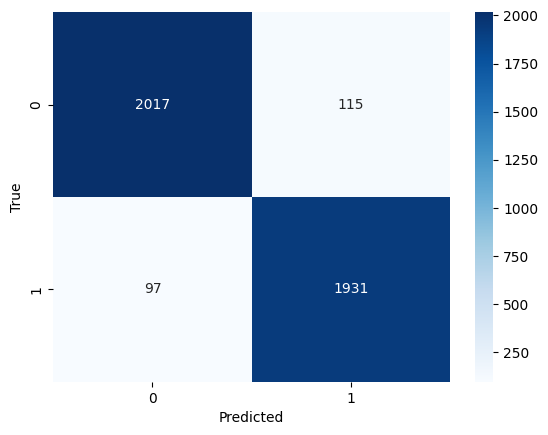

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_test = y_val
y_pred = mlp.predict(X_val)

cm = confusion_matrix(y_test, y_pred)
sns .heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()